# Short Term Load Forecasting using XGBoost

This notebook demonstrates the use of XGBoost for short term load forecasting. It follows the steps in ["Short Term Load Forecasting Using XGBoost"](https://doi.org/10.1007/978-3-030-15035-8_108).

In [9]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tqdm import tqdm

import time
import pickle
import warnings

warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12.8, 7.2)


In [2]:
df = pd.read_csv('../data/BANES_v2.csv', parse_dates=['time'])
# df = df.groupby(['time', 'location']).mean().reset_index()
df.head()

In [ ]:
df = df.sort_values(by=['location', 'time'])

Joining the last week of data will expand the usage up to almost 20 GiB of data. That's too large for the RAM and unnecessary for this.
We will use only around 3 years of data to reduce the RAM usage.

In [ ]:
df = df[df['time'] >= '2017-01-01']

In [5]:
# join the last 7 days of data
for i in tqdm(range(1, 48 * 7 + 1)):
    df.loc[df['time'].shift(i) == df['time'] - pd.Timedelta(i * 30, 'm'), f"energy_lag_{i}"] = df['energy'].shift(i)

100%|██████████| 336/336 [01:51<00:00,  3.02it/s]


In [6]:
df.dropna(inplace=True)
df.head()

,location,time,energy,AirTemp,RelativeHumidity,Dni,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,...,energy_lag_327,energy_lag_328,energy_lag_329,energy_lag_330,energy_lag_331,energy_lag_332,energy_lag_333,energy_lag_334,energy_lag_335,energy_lag_336
188447,##Bishop Sutton Primary School Electricity,2017-01-08 00:00:00+00:00,0.000,8.4,0.987,0.0,0.000,0.0,0.0,0.0,...,0.005,0.005,0.005,0.005,0.006,0.005,0.005,0.000,0.000,0.000
188448,##Bishop Sutton Primary School Electricity,2017-01-08 00:30:00+00:00,0.000,8.3,0.987,0.0,0.000,0.0,0.0,0.0,...,0.006,0.005,0.005,0.005,0.005,0.006,0.005,0.005,0.000,0.000
188449,##Bishop Sutton Primary School Electricity,2017-01-08 01:00:00+00:00,0.000,8.2,0.987,0.0,0.000,0.0,0.0,0.0,...,0.005,0.006,0.005,0.005,0.005,0.005,0.006,0.005,0.005,0.000
188450,##Bishop Sutton Primary School Electricity,2017-01-08 01:30:00+00:00,0.006,8.1,0.987,0.0,0.000,0.0,0.0,0.0,...,0.005,0.005,0.006,0.005,0.005,0.005,0.005,0.006,0.005,0.005
188451,##Bishop Sutton Primary School Electricity,2017-01-08 02:00:00+00:00,0.005,8.0,0.988,0.0,0.006,0.0,0.0,0.0,...,0.005,0.005,0.005,0.006,0.005,0.005,0.005,0.005,0.006,0.005


In [7]:
df.to_csv('../data/BANES_v3_oneweek.csv', index=False)

## Feature Selection

In [3]:
df = pd.read_csv('../data/BANES_v3_oneweek.csv', parse_dates=['time'])
df.head()

,location,time,energy,AirTemp,RelativeHumidity,Dni,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,...,energy_lag_327,energy_lag_328,energy_lag_329,energy_lag_330,energy_lag_331,energy_lag_332,energy_lag_333,energy_lag_334,energy_lag_335,energy_lag_336
0,##Bishop Sutton Primary School Electricity,2017-01-08 00:00:00+00:00,0.000,8.4,0.987,0.0,0.000,0.0,0.0,0.0,...,0.005,0.005,0.005,0.005,0.006,0.005,0.005,0.000,0.000,0.000
1,##Bishop Sutton Primary School Electricity,2017-01-08 00:30:00+00:00,0.000,8.3,0.987,0.0,0.000,0.0,0.0,0.0,...,0.006,0.005,0.005,0.005,0.005,0.006,0.005,0.005,0.000,0.000
2,##Bishop Sutton Primary School Electricity,2017-01-08 01:00:00+00:00,0.000,8.2,0.987,0.0,0.000,0.0,0.0,0.0,...,0.005,0.006,0.005,0.005,0.005,0.005,0.006,0.005,0.005,0.000
3,##Bishop Sutton Primary School Electricity,2017-01-08 01:30:00+00:00,0.006,8.1,0.987,0.0,0.000,0.0,0.0,0.0,...,0.005,0.005,0.006,0.005,0.005,0.005,0.005,0.006,0.005,0.005
4,##Bishop Sutton Primary School Electricity,2017-01-08 02:00:00+00:00,0.005,8.0,0.988,0.0,0.006,0.0,0.0,0.0,...,0.005,0.005,0.005,0.006,0.005,0.005,0.005,0.005,0.006,0.005


In [4]:
df.shape

(2466431, 342)

In [5]:
df.shape[0] * df.shape[1]

843519402

3 years of data is still too large. We'll only use around one year and half.

In [6]:
df = df[(df['time'] >= '2019-01-01') & (df['time'] < '2020-01-01')]

X_vals = df.drop(['energy', 'location', 'time'], axis=1).values
y_vals = df['energy'].values

X_vals[:5], y_vals[:5]

(array([[13.9  ,  0.937,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [13.9  ,  0.942,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [14.   ,  0.948,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [14.1  ,  0.951,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [14.1  ,  0.952,  0.   , ...,  0.   ,  0.   ,  0.   ]]),
 array([1.347, 1.384, 1.344, 1.394, 1.34 ]))

In [7]:
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, tree_method='gpu_hist', verbosity=2)

In [8]:
init = time.time()
model.fit(X_vals, y_vals)
end = time.time()

print('Training time: {:.4f} s'.format(end - init))

Training time: 259.9533 s


In [9]:

# pickle.dump(model, open('../models/model_featureimportance.pkl', 'wb'))

In [10]:
columns = df.drop(['energy', 'location', 'time'], axis=1).columns

In [11]:
feature_importance = pd.Series(model.feature_importances_, index=columns)

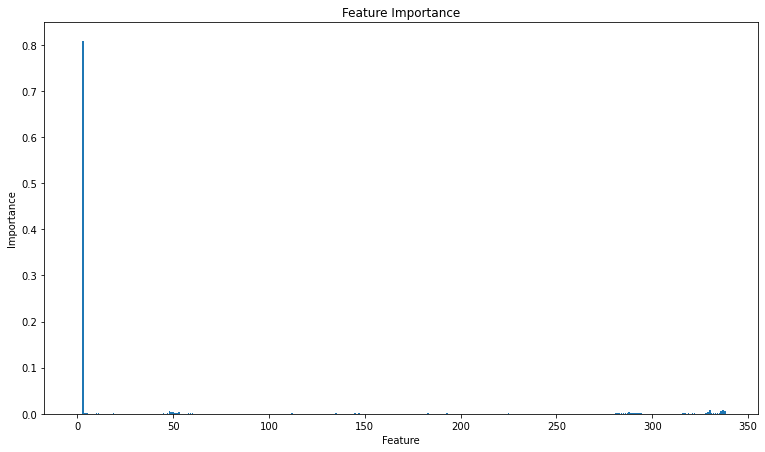

In [12]:
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

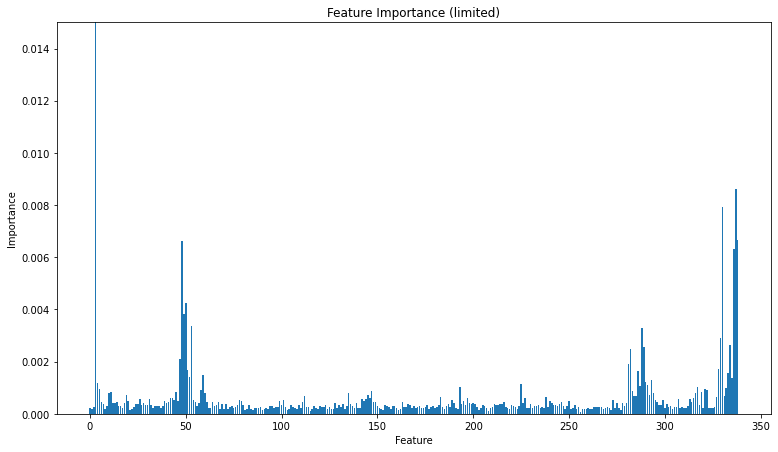

In [13]:
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
# on the top of the bar plot, add the feature names but only for the 20 largest features
plt.title('Feature Importance (limited)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.ylim([0, 0.015])
plt.show()

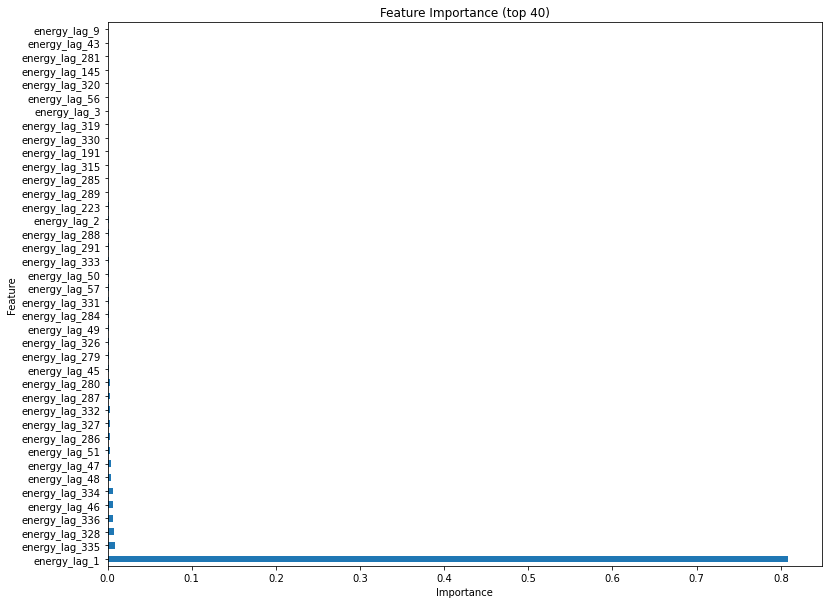

In [14]:
plt.figure(figsize=(12.8, 10))

feature_importance.nlargest(40).plot(kind='barh')
plt.title('Feature Importance (top 40)')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

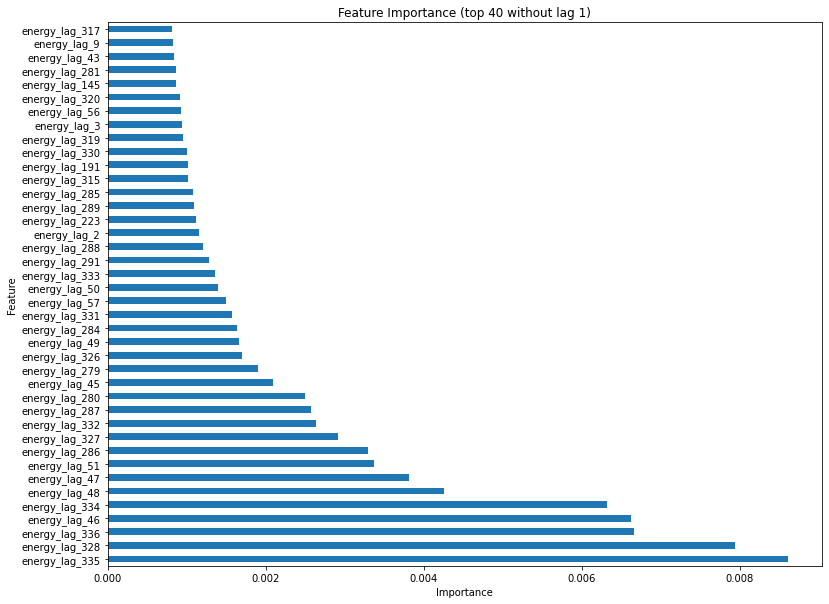

In [15]:
plt.figure(figsize=(12.8, 10))

feature_importance.drop(['energy_lag_1']).nlargest(40).plot(kind='barh')
plt.title('Feature Importance (top 40 without lag 1)')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

In [16]:
features = feature_importance.nlargest(40).index
features

Index(['energy_lag_1', 'energy_lag_335', 'energy_lag_328', 'energy_lag_336',
       'energy_lag_46', 'energy_lag_334', 'energy_lag_48', 'energy_lag_47',
       'energy_lag_51', 'energy_lag_286', 'energy_lag_327', 'energy_lag_332',
       'energy_lag_287', 'energy_lag_280', 'energy_lag_45', 'energy_lag_279',
       'energy_lag_326', 'energy_lag_49', 'energy_lag_284', 'energy_lag_331',
       'energy_lag_57', 'energy_lag_50', 'energy_lag_333', 'energy_lag_291',
       'energy_lag_288', 'energy_lag_2', 'energy_lag_223', 'energy_lag_289',
       'energy_lag_285', 'energy_lag_315', 'energy_lag_191', 'energy_lag_330',
       'energy_lag_319', 'energy_lag_3', 'energy_lag_56', 'energy_lag_320',
       'energy_lag_145', 'energy_lag_281', 'energy_lag_43', 'energy_lag_9'],
      dtype='object')

## Test with features worth > 0.5%

- 5x5 casas
- 1x[7 9 12] casas
- 1x80/20

In [17]:
# feature importance larger than 0.5%
features = feature_importance[feature_importance > 0.005].index
features

Index(['energy_lag_1', 'energy_lag_46', 'energy_lag_328', 'energy_lag_334',
       'energy_lag_335', 'energy_lag_336'],
      dtype='object')

In [19]:
df_05 = df[[*features] + ['energy', 'location']]
df_05.head()

,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336,energy,location
33650,1.344,1.414,0.0,0.0,0.0,0.0,1.347,##Northgate House Electricity Supply 1
33651,1.347,1.359,0.0,0.0,0.0,0.0,1.384,##Northgate House Electricity Supply 1
33652,1.384,1.381,0.0,0.0,0.0,0.0,1.344,##Northgate House Electricity Supply 1
33653,1.344,1.296,0.0,0.0,0.0,0.0,1.394,##Northgate House Electricity Supply 1
33654,1.394,1.313,0.0,0.0,0.0,0.0,1.340,##Northgate House Electricity Supply 1


As we can see, the half hour before the energy is the most important, with around the same hour the day before and the last week being also somewhat important.

### 5x5 houses

In [23]:
models = [xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, tree_method='gpu_hist', verbosity=2) for
          _ in range(5)]

In [24]:
for model in models:
    # get 5 random houses
    random_locations = np.random.choice(df['location'].unique(), size=5, replace=False)
    # use the 5 houses as the test set
    test = df_05[df_05['location'].isin(random_locations)]
    # remove the houses from the training set
    train = df_05[~df_05['location'].isin(random_locations)]
    X_train = train.drop(['energy', 'location'], axis=1).values
    y_train = train['energy'].values
    X_test = test.drop(['energy', 'location'], axis=1).values
    y_test = test['energy'].values

    init = time.time()
    model.fit(X_train, y_train)
    end = time.time()

    print('Training time: {:.4f} s'.format(end - init))

    init = time.time()
    y_pred = model.predict(X_test)
    end = time.time()

    print('Prediction time: {:.4f} s'.format(end - init))

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    wmape = np.sum(np.abs(y_pred - y_test)) / np.sum(np.abs(y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    print('MSE: {:.4f}'.format(mse))
    print('RMSE: {:.4f}'.format(rmse))
    print('MAE: {:.4f}'.format(mae))
    print('WMAPE: {:.4f}'.format(wmape))
    print('R2: {:.4f}\n'.format(r2))


Training time: 14.7672 s
Prediction time: 0.2244 s
MSE: 0.3704
RMSE: 0.6086
MAE: 0.3053
WMAPE: 18.9405
R2: 0.9234

Training time: 14.0753 s
Prediction time: 0.1893 s
MSE: 0.1798
RMSE: 0.4240
MAE: 0.1727
WMAPE: 21.2881
R2: 0.9048

Training time: 14.4677 s
Prediction time: 0.2756 s
MSE: 1.3460
RMSE: 1.1602
MAE: 0.4177
WMAPE: 11.9769
R2: 0.9708

Training time: 14.0565 s
Prediction time: 0.3514 s
MSE: 0.2441
RMSE: 0.4940
MAE: 0.1861
WMAPE: 14.9444
R2: 0.9519

Training time: 14.4625 s
Prediction time: 0.2330 s
MSE: 0.3098
RMSE: 0.5566
MAE: 0.1819
WMAPE: 17.4994
R2: 0.9234



### 80/20 split

In [47]:
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, tree_method='gpu_hist', verbosity=2)

In [48]:
dddf = pd.read_csv('../data/BANES_v5_featureimportance.csv', parse_dates=['time'])
X_train, X_test, y_train, y_test = train_test_split(dddf.drop(['energy', 'location', 'time'], axis=1), dddf['energy'],
                                                    test_size=0.2, random_state=42)

In [49]:
init = time.time()
model.fit(X_train, y_train)
end = time.time()

print('Training time: {:.4f} s'.format(end - init))

init = time.time()
y_pred = model.predict(X_test)
end = time.time()

print('Prediction time: {:.4f} s'.format(end - init))

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
wmape = np.sum(np.abs(y_pred - y_test)) / np.sum(np.abs(y_test)) * 100
r2 = r2_score(y_test, y_pred)

print('MSE: {:.4f}'.format(mse))
print('RMSE: {:.4f}'.format(rmse))
print('MAE: {:.4f}'.format(mae))
print('WMAPE: {:.4f}'.format(wmape))
print('R2: {:.4f}\n'.format(r2))


Training time: 85.1919 s
Prediction time: 7.0898 s
MSE: 0.7158
RMSE: 0.8461
MAE: 0.3310
WMAPE: 8.1688
R2: 0.9900



### 10 houses and 15 houses

In [29]:
models = [xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, tree_method='gpu_hist', verbosity=2) for
          _ in range(10)]

In [32]:
for i, model in enumerate(models):
    if i >= 5:
        print("15 houses")
        i = i - 5
        # get 15 random houses
        locations = np.random.choice(df['location'].unique(), size=15, replace=False)
    else:
        print("10 houses")
        # get 10 random houses
        locations = np.random.choice(df['location'].unique(), size=10, replace=False)

    print('Model {}'.format(i + 1))

    # use the houses as the test set
    test = df_05[df_05['location'].isin(locations)]
    # remove the houses from the training set
    train = df_05[~df_05['location'].isin(locations)]
    X_train = train.drop(['energy', 'location'], axis=1).values
    y_train = train['energy'].values

    init = time.time()
    model.fit(X_train, y_train)
    end = time.time()

    print('Training time: {:.4f} s'.format(end - init))

    init = time.time()
    y_pred = model.predict(X_test)
    end = time.time()

    print('Prediction time: {:.4f} s'.format(end - init))

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    wmape = np.sum(np.abs(y_pred - y_test)) / np.sum(np.abs(y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    print('MSE: {:.4f}'.format(mse))
    print('RMSE: {:.4f}'.format(rmse))
    print('MAE: {:.4f}'.format(mae))
    print('WMAPE: {:.4f}'.format(wmape))
    print('R2: {:.4f}\n'.format(r2))


10 houses
Model 1
Training time: 14.1847 s
Prediction time: 0.5532 s
MSE: 0.5044
RMSE: 0.7102
MAE: 0.2904
WMAPE: 9.4635
R2: 0.9881

10 houses
Model 2
Training time: 13.8021 s
Prediction time: 0.7017 s
MSE: 0.4252
RMSE: 0.6521
MAE: 0.2804
WMAPE: 9.1346
R2: 0.9899

10 houses
Model 3
Training time: 13.1502 s
Prediction time: 0.7264 s
MSE: 0.4973
RMSE: 0.7052
MAE: 0.2884
WMAPE: 9.3974
R2: 0.9882

10 houses
Model 4
Training time: 13.2155 s
Prediction time: 0.7201 s
MSE: 0.5460
RMSE: 0.7389
MAE: 0.3022
WMAPE: 9.8449
R2: 0.9871

10 houses
Model 5
Training time: 13.1910 s
Prediction time: 0.8567 s
MSE: 0.5060
RMSE: 0.7114
MAE: 0.2911
WMAPE: 9.4851
R2: 0.9880

15 houses
Model 1
Training time: 12.6170 s
Prediction time: 0.7609 s
MSE: 0.4328
RMSE: 0.6578
MAE: 0.2817
WMAPE: 9.1798
R2: 0.9898

15 houses
Model 2
Training time: 13.0302 s
Prediction time: 1.0387 s
MSE: 0.4740
RMSE: 0.6885
MAE: 0.2874
WMAPE: 9.3646
R2: 0.9888

15 houses
Model 3
Training time: 12.2479 s
Prediction time: 0.6212 s
MSE: 0.

## Export Data with the top 40 features

In [35]:
if features is not None:
    features = ['energy_lag_1', 'energy_lag_335', 'energy_lag_328', 'energy_lag_336',
                'energy_lag_46', 'energy_lag_334', 'energy_lag_48', 'energy_lag_47',
                'energy_lag_51', 'energy_lag_286', 'energy_lag_327', 'energy_lag_332',
                'energy_lag_287', 'energy_lag_280', 'energy_lag_45', 'energy_lag_279',
                'energy_lag_326', 'energy_lag_49', 'energy_lag_284', 'energy_lag_331',
                'energy_lag_57', 'energy_lag_50', 'energy_lag_333', 'energy_lag_291',
                'energy_lag_288', 'energy_lag_2', 'energy_lag_223', 'energy_lag_289',
                'energy_lag_285', 'energy_lag_315', 'energy_lag_191', 'energy_lag_330',
                'energy_lag_319', 'energy_lag_3', 'energy_lag_56', 'energy_lag_320',
                'energy_lag_145', 'energy_lag_281', 'energy_lag_43', 'energy_lag_9']

features = [int(f.split("_")[-1]) for f in features]
features

[1,
 335,
 328,
 336,
 46,
 334,
 48,
 47,
 51,
 286,
 327,
 332,
 287,
 280,
 45,
 279,
 326,
 49,
 284,
 331,
 57,
 50,
 333,
 291,
 288,
 2,
 223,
 289,
 285,
 315,
 191,
 330,
 319,
 3,
 56,
 320,
 145,
 281,
 43,
 9]

In [36]:
ddf = pd.read_csv('../data/BANES_v2.csv', parse_dates=['time'])

In [37]:
for i in tqdm(range(len(features))):
    f = features[i]
    ddf.loc[ddf['time'].shift(f) == ddf['time'] - pd.Timedelta(f * 30, 'm'), f"energy_lag_{f}"] = ddf['energy'].shift(f)

100%|██████████| 40/40 [01:00<00:00,  1.52s/it]


In [38]:
ddf = ddf.dropna()


In [26]:
ddf.to_csv('../data/BANES_v4_featureimportance.csv', index=False)

# XGBoost training

In [39]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7618080 entries, 336 to 7759967
Data columns (total 46 columns):
 #   Column            Dtype              
---  ------            -----              
 0   location          object             
 1   time              datetime64[ns, UTC]
 2   energy            float64            
 3   AirTemp           float64            
 4   RelativeHumidity  float64            
 5   Dni               float64            
 6   energy_lag_1      float64            
 7   energy_lag_335    float64            
 8   energy_lag_328    float64            
 9   energy_lag_336    float64            
 10  energy_lag_46     float64            
 11  energy_lag_334    float64            
 12  energy_lag_48     float64            
 13  energy_lag_47     float64            
 14  energy_lag_51     float64            
 15  energy_lag_286    float64            
 16  energy_lag_327    float64            
 17  energy_lag_332    float64            
 18  energy_lag_287    fl

In [40]:
ddf.describe()

,energy,AirTemp,RelativeHumidity,Dni,energy_lag_1,energy_lag_335,energy_lag_328,energy_lag_336,energy_lag_46,energy_lag_334,...,energy_lag_191,energy_lag_330,energy_lag_319,energy_lag_3,energy_lag_56,energy_lag_320,energy_lag_145,energy_lag_281,energy_lag_43,energy_lag_9
count,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,...,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06
mean,4.047301e+00,1.037881e+01,8.224648e-01,9.455131e+01,4.047312e+00,4.045883e+00,4.045944e+00,4.045876e+00,4.047256e+00,4.045890e+00,...,4.046697e+00,4.045925e+00,4.046136e+00,4.047327e+00,4.047236e+00,4.046105e+00,4.046361e+00,4.046634e+00,4.047247e+00,4.047365e+00
std,8.456606e+00,5.630281e+00,1.291052e-01,2.143843e+02,8.456609e+00,8.456215e+00,8.456158e+00,8.456223e+00,8.456330e+00,8.456208e+00,...,8.456546e+00,8.456171e+00,8.456273e+00,8.456609e+00,8.456302e+00,8.456240e+00,8.455656e+00,8.457047e+00,8.456333e+00,8.456579e+00
min,0.000000e+00,-9.000000e+00,3.060000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.290000e-01,6.400000e+00,7.450000e-01,0.000000e+00,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,...,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01
50%,7.630000e-01,1.030000e+01,8.590000e-01,0.000000e+00,7.630000e-01,7.620000e-01,7.620000e-01,7.620000e-01,7.630000e-01,7.620000e-01,...,7.630000e-01,7.620000e-01,7.620000e-01,7.630000e-01,7.630000e-01,7.620000e-01,7.630000e-01,7.630000e-01,7.630000e-01,7.630000e-01
75%,3.258000e+00,1.440000e+01,9.260000e-01,1.500000e+01,3.258000e+00,3.255000e+00,3.255000e+00,3.255000e+00,3.258000e+00,3.255000e+00,...,3.256000e+00,3.255000e+00,3.255000e+00,3.258000e+00,3.258000e+00,3.255000e+00,3.257000e+00,3.256000e+00,3.258000e+00,3.259000e+00
max,7.470000e+01,2.970000e+01,1.000000e+00,9.460000e+02,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,...,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01


In [41]:
X_train, X_test, y_train, y_test = train_test_split(ddf[[f"energy_lag_{f}" for f in features]], ddf['energy'],
                                                    test_size=0.2, random_state=42)

In [44]:

model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, tree_method='gpu_hist', verbosity=2)

In [45]:
init = time.time()
model.fit(X_train, y_train)
end = time.time()

print('Training time: {:.4f} s'.format(end - init))

Training time: 285.3513 s


In [46]:
init = time.time()
preds = model.predict(X_test)
end = time.time()

print('Prediction time: {:.4f} s'.format(end - init))

Prediction time: 9.9936 s


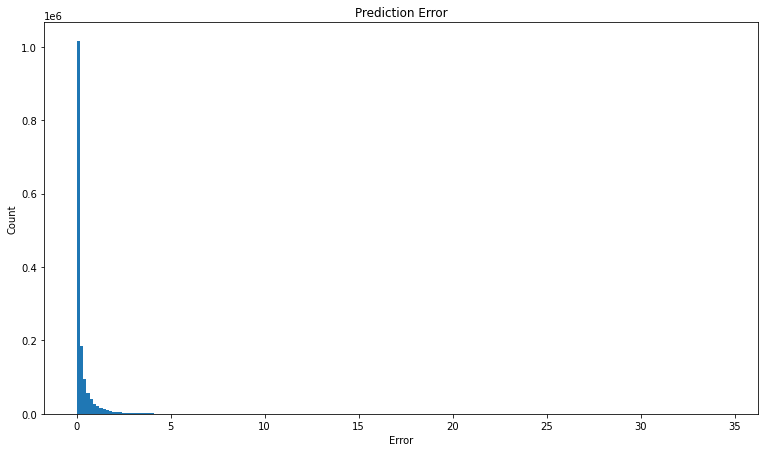

In [47]:
# plot error histogram
plt.hist(np.abs(preds - y_test), bins=200)
plt.title('Prediction Error')
plt.xlabel('Error')
plt.ylabel('Count')
plt.show()

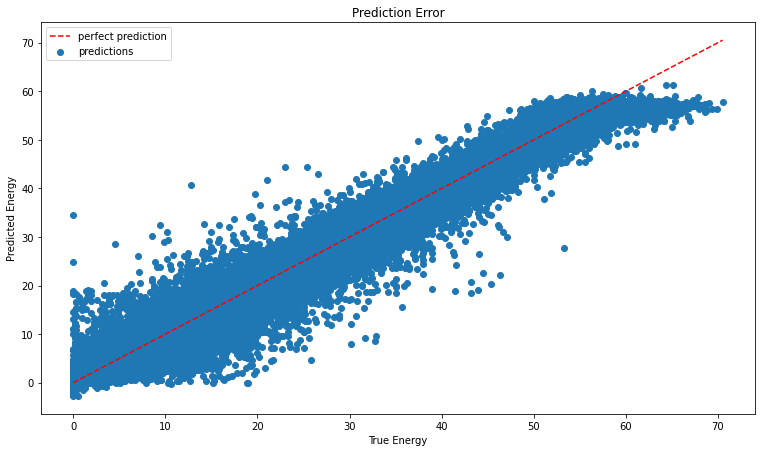

In [48]:
plt.scatter(y_test, preds)
plt.title('Prediction Error')
plt.xlabel('True Energy')
plt.ylabel('Predicted Energy')
plt.plot([0, max(y_test)], [0, max(y_test)], '--', color='red')
plt.legend(['perfect prediction', 'predictions'])
plt.show()

In [49]:
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)
wmape = np.sum(np.abs(preds - y_test)) / np.sum(np.abs(y_test)) * 100
r2 = r2_score(y_test, preds)

print('MSE: {:.4f} kWh'.format(mse))
print('RMSE: {:.4f} kWh'.format(rmse))
print('MAE: {:.4f} kWh'.format(mae))
print('WMAPE: {:.4f} %'.format(wmape))
print('R2: {:.4f}'.format(r2))


MSE: 0.5210 kWh
RMSE: 0.7218 kWh
MAE: 0.2930 kWh
WMAPE: 7.2313 %
R2: 0.9927


## Use houses as training data

In [50]:
ddf.location.nunique()

69

In [51]:
ddf.location.value_counts()

Guildhall Electricity Supply 1 (HH)              228384
Bath Central Library Electricity (HH)            224784
##Weston Library Electricity Supply 1            197376
Royal Victoria Park Nursery Electricity          196848
Moorland Rd Library                              194304
                                                  ...  
Mechanical Control Panel 1                         7536
Ground & First Floor North - Power & Lighting      7536
Air cooled chiller 1                               2352
AirCooled Chiller 2                                 432
Ground Floor Disabled WC Water Heater                96
Name: location, Length: 69, dtype: int64

In [52]:
# get 10 random locations
locations = ddf.location.sample(10).values
locations

array(['St Johns Catholic Primary (P272 HH)',
       'Saltford C of E Primary School (P272 HH)', 'Lewis House (New HH)',
       'Guildhall Electricity Supply 1 (HH)',
       'St Saviours C of E Infant School',
       'Midsomer Norton Library (P272 HH)',
       'St Saviours C of E Infant School',
       '##Northgate House Electricity Supply 2',
       'St Marks C of E School (HH)',
       'St Marks C of E School - Orchard Lodge'], dtype=object)

In [53]:
test = ddf[ddf.location.isin(locations)]
train = ddf[~ddf.location.isin(locations)]
print(test.shape, train.shape)

X_train = train[[f"energy_lag_{f}" for f in features]]
y_train = train['energy']
X_test = test[[f"energy_lag_{f}" for f in features]]
y_test = test['energy']

(1467888, 46) (6150192, 46)


In [54]:
test.shape[0] / train.shape[0] * 100

23.867352433875237

In [65]:

model2 = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, tree_method='gpu_hist', verbosity=2)

In [6]:
init = time.time()
model2.fit(X_train, y_train)
end = time.time()

print('Training time: {:.4f} s'.format(end - init))

Training time: 246.7055 s


In [ ]:
init = time.time()
preds2 = model2.predict(X_test)
end = time.time()

print('Prediction time: {:.4f} s'.format(end - init))

Prediction time: 9.5662 s


In [ ]:
mse = mean_squared_error(y_test, preds2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds2)
wmape = np.sum(np.abs(preds2 - y_test)) / np.sum(np.abs(y_test)) * 100
r2 = r2_score(y_test, preds2)

print('MSE: {:.4f} kWh'.format(mse))
print('RMSE: {:.4f} kWh'.format(rmse))
print('MAE: {:.4f} kWh'.format(mae))
print('WMAPE: {:.4f} %'.format(wmape))
print('R2: {:.4f}'.format(r2))

MSE: 2.4923 kWh
RMSE: 1.5787 kWh
MAE: 0.7686 kWh
WMAPE: 7.1454 %
R2: 0.9871


### Export the model

This section will run the best model on the all dataset and export it as a pickle file.

In [10]:
features = ['energy_lag_1', 'energy_lag_46', 'energy_lag_328', 'energy_lag_334',
            'energy_lag_335', 'energy_lag_336']

In [12]:
cols = ["time", "location", "energy"] + features
df = pd.read_csv('../data/BANES_v5_featureimportance.csv', usecols=cols)
df.head(10)

,time,location,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336
0,2008-06-21 00:30:00+00:00,## OLD Paulton Library Electricity Supply 1,0.07,0.08,0.08,0.08,0.08,0.07,0.08
1,2008-06-21 01:00:00+00:00,## OLD Paulton Library Electricity Supply 1,0.08,0.07,0.07,0.08,0.07,0.08,0.07
2,2008-06-21 01:30:00+00:00,## OLD Paulton Library Electricity Supply 1,0.07,0.08,0.08,0.08,0.08,0.07,0.08
3,2008-06-21 02:00:00+00:00,## OLD Paulton Library Electricity Supply 1,0.08,0.07,0.07,0.08,0.07,0.08,0.07
4,2008-06-21 02:30:00+00:00,## OLD Paulton Library Electricity Supply 1,0.07,0.08,0.08,0.07,0.08,0.07,0.08
5,2008-06-21 03:00:00+00:00,## OLD Paulton Library Electricity Supply 1,0.08,0.07,0.08,0.08,0.07,0.08,0.07
6,2008-06-21 03:30:00+00:00,## OLD Paulton Library Electricity Supply 1,0.07,0.08,0.08,0.07,0.08,0.07,0.08
7,2008-06-21 04:00:00+00:00,## OLD Paulton Library Electricity Supply 1,0.08,0.07,0.08,0.44,0.08,0.08,0.07
8,2008-06-21 04:30:00+00:00,## OLD Paulton Library Electricity Supply 1,0.08,0.08,0.07,0.38,0.08,0.08,0.08
9,2008-06-21 05:00:00+00:00,## OLD Paulton Library Electricity Supply 1,0.08,0.08,0.08,0.37,0.08,0.08,0.08


In [13]:
df.location.value_counts()

Guildhall Electricity Supply 1 (HH)              228384
Bath Central Library Electricity (HH)            224784
##Weston Library Electricity Supply 1            197376
Royal Victoria Park Nursery Electricity          196848
Moorland Rd Library                              194304
                                                  ...  
Mechanical Control Panel 1                         7536
Ground & First Floor North - Power & Lighting      7536
Air cooled chiller 1                               2352
AirCooled Chiller 2                                 432
Ground Floor Disabled WC Water Heater                96
Name: location, Length: 69, dtype: int64

In [14]:
locations = ['St Marks C of E School - Orchard Lodge',
       'Haycombe Cemetery Chapel Electricity Sup',
       'Freshford C of E Primary Electricity Sup',
       'Keynsham Childrens Centre - Castle School Annexe',
       'The Hollies Offices MSN (P272 HH)',
       'Infants School - Main School 1',
       'Westfield Childrens Centre (Now Schools Responsibility)',
       'Pensford Primary Electricity Supply 3',
       'The Hollies Offices MSN (P272 HH)',
       'Junior School Electricity - Kitchen']

In [15]:
test = df[df.location.isin(locations)]
train = df[~df.location.isin(locations)]
print("Test corresponds to {}% of the data".format(test.shape[0] / df.shape[0] * 100))

X_train = train[features]
y_train = train['energy']
X_test = test[features]
y_test = test['energy']

Test corresponds to 18.04675193749606% of the data


In [19]:
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, tree_method='gpu_hist', verbosity=2)

In [20]:
init = time.time()
model.fit(X_train, y_train)
end = time.time()

print('Training time: {:.4f} s'.format(end - init))

# save model
pickle.dump(model, open('../models/model_v1.pkl', 'wb'))

init = time.time()
preds = model.predict(X_test)
end = time.time()

print('Prediction time: {:.4f} s'.format(end - init))

mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)
wmape = np.sum(np.abs(preds - y_test)) / np.sum(np.abs(y_test)) * 100
r2 = r2_score(y_test, preds)

print('MSE: {:.4f} kWh'.format(mse))
print('RMSE: {:.4f} kWh'.format(rmse))
print('MAE: {:.4f} kWh'.format(mae))
print('WMAPE: {:.4f} %'.format(wmape))
print('R2: {:.4f}'.format(r2))

Training time: 81.8671 s
Prediction time: 8.2916 s
MSE: 0.1463 kWh
RMSE: 0.3824 kWh
MAE: 0.1623 kWh
WMAPE: 9.4086 %
R2: 0.9879


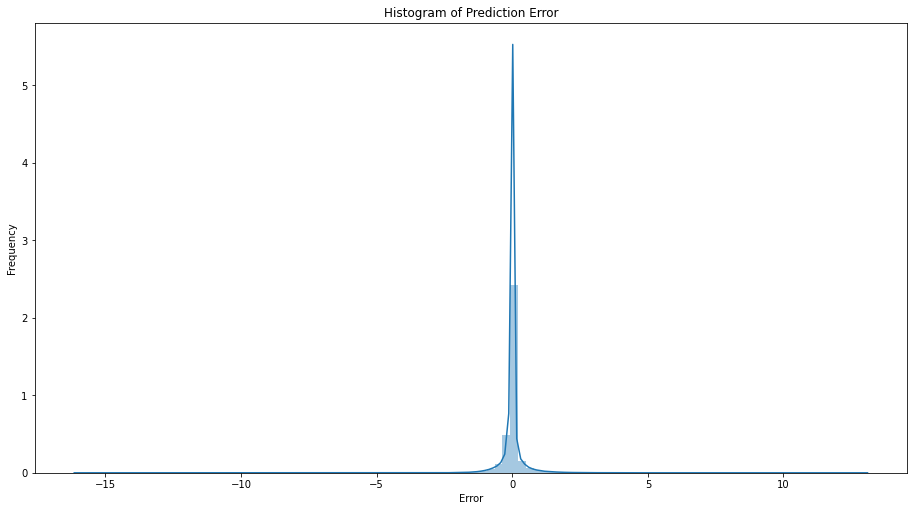

In [32]:
import seaborn as sns

# plt.figure(figsize=(12.8, 7.2))
# plot prediction error with seaborn
sns.distplot(y_test - preds, bins=100)
# plt.scatter(y_test, preds)
plt.title('Histogram of Prediction Error')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

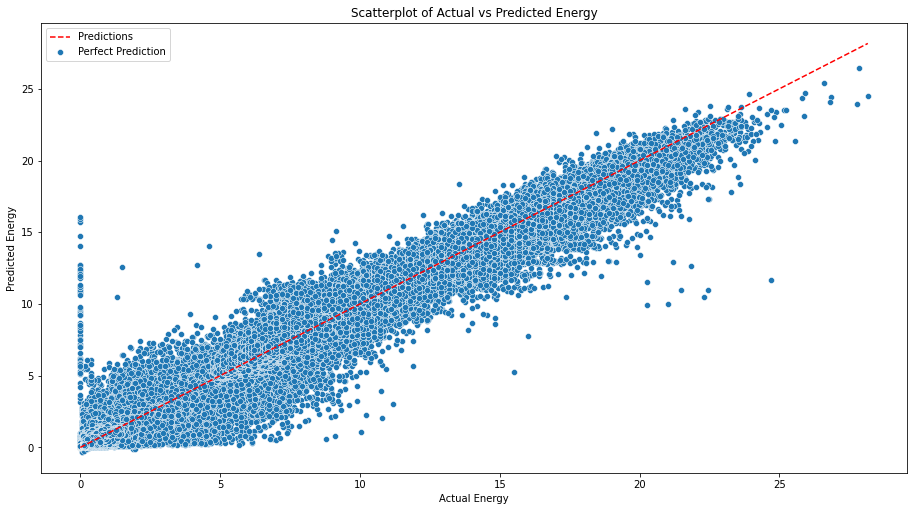

In [31]:
sns.scatterplot(y_test, preds)
plt.title('Scatterplot of Actual vs Predicted Energy')
plt.xlabel('Actual Energy')
plt.ylabel('Predicted Energy')
plt.tight_layout()
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.legend(['Predictions', 'Perfect Prediction'])
plt.show()

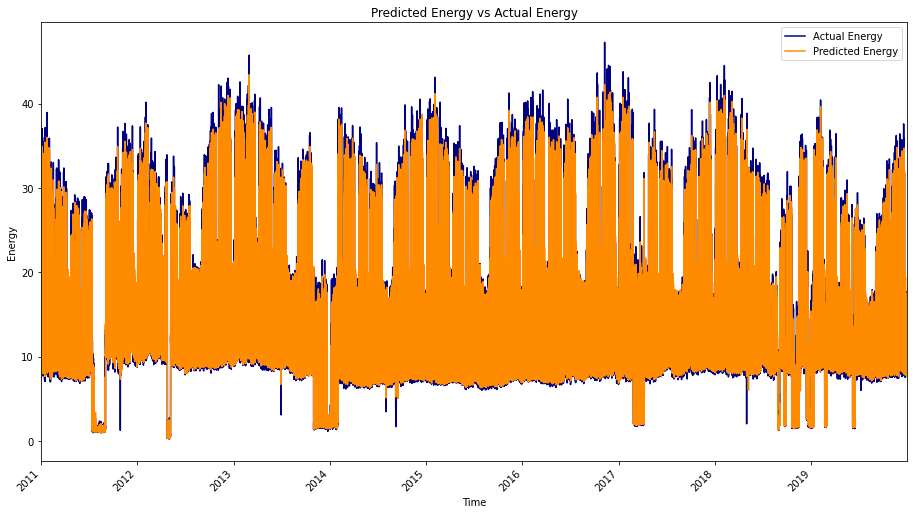

In [41]:
community_preds = test.copy()
community_preds['preds'] = preds
community_preds = community_preds.groupby('time').sum().reset_index()
community_preds["time"] = pd.to_datetime(community_preds["time"])
ax = community_preds.plot(x='time', y='energy', c="navy", label="Actual Energy")
community_preds.plot(x='time', y='preds', ax=ax, figsize=(12.8, 7.2), c="darkorange", label="Predicted Energy")
plt.title('Predicted Energy vs Actual Energy')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.tight_layout()
plt.xticks(rotation=45)
plt.legend()
# only show data after 2011
plt.xlim(pd.to_datetime('2011-01-01'), pd.to_datetime('2019-12-31'))
plt.show()

In [46]:
mse = mean_squared_error(community_preds["energy"], community_preds["preds"])
rmse = np.sqrt(mse)
mae = mean_absolute_error(community_preds["energy"], community_preds["preds"])
wmape = np.sum(np.abs(community_preds["preds"] - community_preds["energy"])) / np.sum(np.abs(community_preds["energy"])) * 100
r2 = r2_score(y_test, preds)

print('MSE: {:.4f} kWh'.format(mse))
print('RMSE: {:.4f} kWh'.format(rmse))
print('MAE: {:.4f} kWh'.format(mae))
print('WMAPE: {:.4f} %'.format(wmape))
print('R2: {:.4f}'.format(r2))

MSE: 1.2849 kWh
RMSE: 1.1335 kWh
MAE: 0.6832 kWh
WMAPE: 5.7574 %
R2: 0.9879


In [ ]:
# df.to_csv('data/BANES_v4_featureimportance.csv', index=False)